# Running BAVARIA on PBMC data

In this tutorial we show how to run BAVARIA on two PBMC samples which we have prepared in the previous tutorial (00_preparation).
In case you want to skip the data preparation steps in previous tutorial, we have prepared the required input dataset which
you can download from  https://drive.google.com/file/d/1YXciVrcUSlDf9Br-NLb4z9ZFqh2KkIuO/view?usp=share_link.

Below, we shall run BAVARIA once using batch-adversarial training and once without using it to compare the effect
on the integration.

In [1]:
import os
import anndata
import scanpy as sc
import numpy as np


In [2]:
adata = anndata.read_h5ad('data/pbmc_10X.h5ad')

We built a command-line interface for BAVARIA that allow to run the the program e.g. on a HPC environment.
Since, BAVARIA is built using tensorflow/keras, we recommend to employ the program on GPUs as this may speedup the run-time significantly. On the example dataset, each epoch will approximately require 5 sec. w/o batch correction and about 7-8 sec. with batch-adversarial training.

First, we run bavaria without batch correction. This is achieved by using the `-modelname vae` argument for the command line argument. The other arguments that we use here concern the number epochs (`-epochs 200`), the number of models in the ensemble (`-nrepeat 10`), the number of latent features (`-nlatent 10`), the batch size (`-batch_size 128`), the number of neurons in the hidden layer of the decoder (`-nhidden_d 20`) and the fraction of features used for each model (`-feature_fraction 0.5`). The last option will use a 50% random selection of all features (e.g. peaks) for the model fitting. In the ensemble, each model of the 10 individual models may use a different 50% feature set.

(To run bavaria within the notebook, you can convert the following cell to a code cell)

!CUDA_VISIBLE_DEVICES=0 bavaria -data data/pbmc_10X.h5ad \
 -output data/bavaria_10X_pbmc_integration_no_correction \
 -epochs 200 -nrepeat 10 -nlatent 10 -batch_size 128 -nhidden_d 20 \
 -feature_fraction .5 \
 -modelname vae

The resulting low-dimensional embedding can be loaded as follows

In [3]:
results0 = anndata.read_h5ad('data/bavaria_10X_pbmc_integration_no_correction/analysis.h5ad')

Next, keeping all other hyper-parameters fixed, we fit variational auto-encoder using batch-adversarial training (using `-modelname bavaria`). This option also requires to specify one or more batch columns that are stored in the AnnData object. In our case, we make use of the batch column using `-batchnames batch`.

!CUDA_VISIBLE_DEVICES=0 bavaria -data data/pbmc_10X.h5ad \
 -output data/bavaria_10X_pbmc_integration \
 -epochs 200 -nrepeat 10 -nlatent 10 -batch_size 128 -nhidden_d 20 \
 -feature_fraction .5 \
 -batchnames batch -modelname bavaria


In [4]:
results = anndata.read_h5ad('data/bavaria_10X_pbmc_integration/analysis.h5ad')

In [5]:
results0.obs.loc[:,'sample'] = results.obs.batch

From the UMAP without batch correction we can appreciate batch effects between the two PBMC samples.

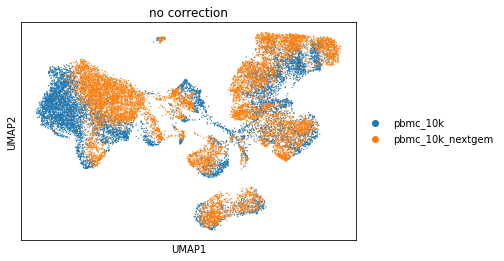

In [6]:
sc.pl.umap(results0, color='sample', title='no correction')

On the other hand, with batch-adversarial training, the PBMC samples are better aligned.

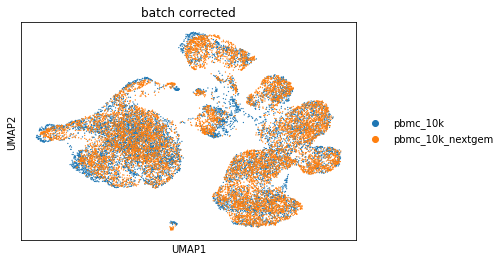

In [7]:
sc.pl.umap(results, color='batch', title='batch corrected')

# Summary

In this notebook we ran BAVARIA once using and once without using batch-correction.
We observe that after batch-correction, the cells from different datasets are mixing more uniformely compared
to when we do not correct for batch-effects.

Depending on the dataset at hand, one might want to consider different parameter choices when running BAVARIA.
For example, to speedup the analysis, one could try to fit the model using fewer epochs, use fewer repetitions for the ensemble or use a smaller fraction of the features. If the quality of the result seems insufficient, on the other hand, one could try to increase the number epochs and/or the ensemble size.